Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.


Retrieving SummaryDoc documents:   0%|          | 0/6385 [00:00<?, ?it/s]

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

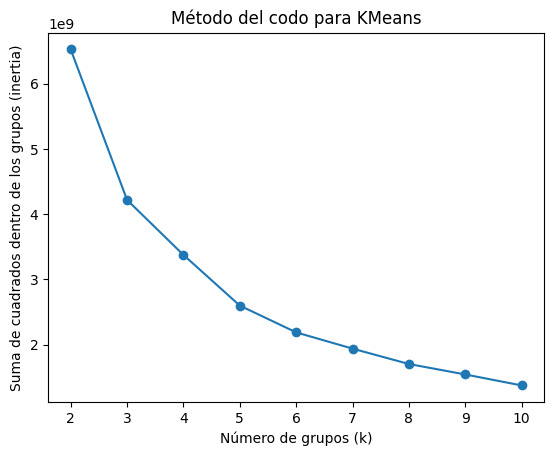

In [30]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mp_api.client import MPRester
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf

# Conectar con la base de datos de materials project usando la API de pymatgen
# Reemplaza "YOUR_API_KEY" con tu clave de API obtenida desde el sitio web de materials project
mpr = MPRester("Q4KseBQeiCIFmpyIzcxTaWeQ0DVWzyZf")

# Obtener los datos de materiales que quieres analizar
# En este ejemplo, se obtienen los datos de los óxidos binarios con una energía de formación menor que -1 eV/átomo
# Se seleccionan las propiedades: identificador del material (material_id), fórmula reducida (reduced_cell_formula), energía de formación (formation_energy_per_atom) y volumen (volume)
docs = mpr.summary.search(elements=[["Si"],['Fe']], 
                           band_gap=(0.0, 1.0))

# # Convertir los resultados en un dataframe
df = pd.DataFrame([material.__dict__ for material in docs])

# df = pd.read_csv('todo_mat')
# df = df[0:50]

# Aplicar algún método de reducción de dimensionalidad o selección de características para simplificar los datos
# En este ejemplo, se usa la función auto_featurize de matminer para generar automáticamente características a partir de la composición química
# Se usan las siguientes clases de características: ElementProperty, Stoichiometry, ValenceOrbital, IonProperty y ElementFraction
feature_classes = [cf.ElementProperty.from_preset("magpie"), cf.Stoichiometry(), cf.ValenceOrbital(props=["avg"]), cf.IonProperty(), cf.ElementFraction()]
featurizer = MultipleFeaturizer(feature_classes)
X = featurizer.fit_transform(df['composition'])

X_df = pd.DataFrame(X)
X_df = X_df.dropna(axis=1) # Eliminar las columnas con valores nulos

# Elegir un algoritmo de clustering adecuado para los datos
# En este ejemplo, se usa el algoritmo KMeans de sklearn para agrupar los datos en k grupos según su similitud
# Se elige el valor de k usando el método del codo, que consiste en variar el valor de k y observar el cambio en la suma de cuadrados dentro de los grupos (inertia)
ks = range(2, 11) # Probar valores de k entre 2 y 10
inertias = [] # Lista para guardar los valores de inertia para cada k
for k in ks:
    # Crear el modelo de KMeans con k grupos
    model = KMeans(n_clusters=k, random_state=0)
    # Entrenar el modelo con los datos
    model.fit(X_df)
    # Añadir el valor de inertia a la lista
    inertias.append(model.inertia_)

# Graficar los valores de k e inertia
plt.plot(ks, inertias, "-o")
plt.xlabel("Número de grupos (k)")
plt.ylabel("Suma de cuadrados dentro de los grupos (inertia)")
plt.title("Método del codo para KMeans")
plt.show()


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Coeficiente de silueta: 0.54 con 3 clusters
Índice Davies-Bouldin: 0.79 con 3 clusters
Coeficiente de silueta: 0.55 con 4 clusters
Índice Davies-Bouldin: 0.76 con 4 clusters
Coeficiente de silueta: 0.47 con 5 clusters
Índice Davies-Bouldin: 0.81 con 5 clusters
Coeficiente de silueta: 0.48 con 6 clusters
Índice Davies-Bouldin: 0.88 con 6 clusters
Coeficiente de silueta: 0.47 con 7 clusters
Índice Davies-Bouldin: 0.92 con 7 clusters
Coeficiente de silueta: 0.48 con 8 clusters
Índice Davies-Bouldin: 0.86 con 8 clusters


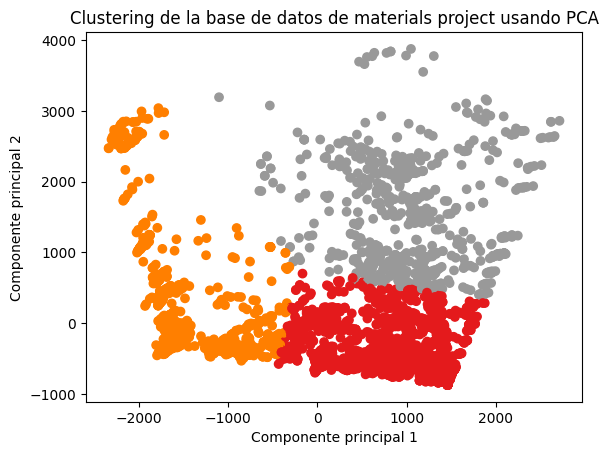

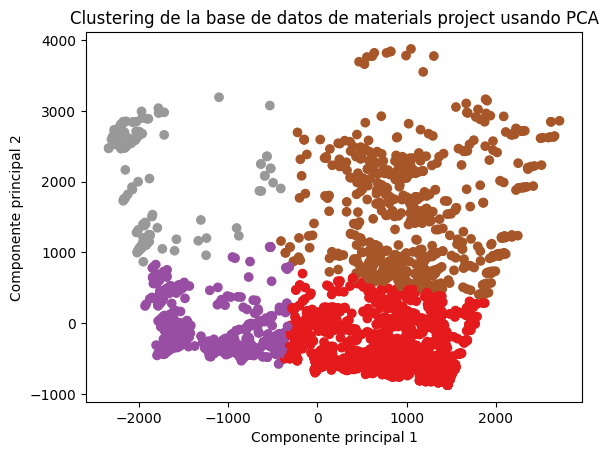

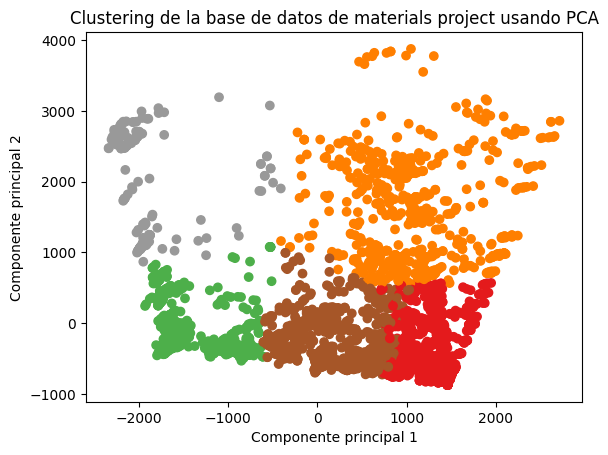

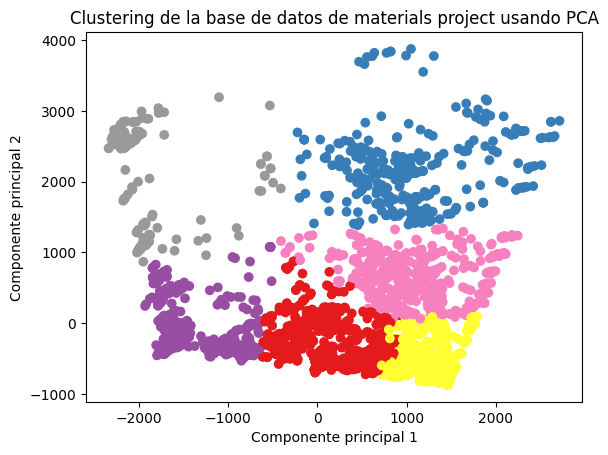

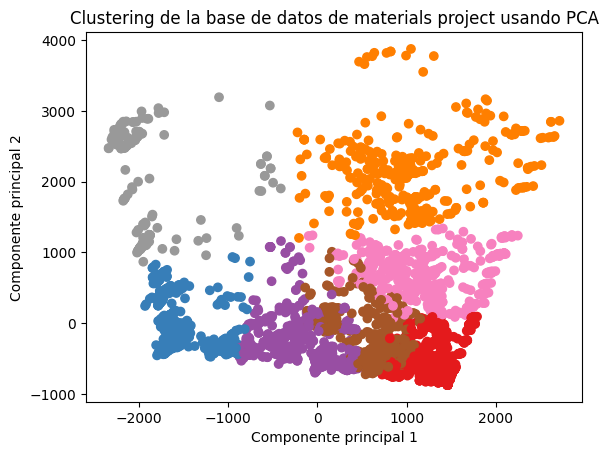

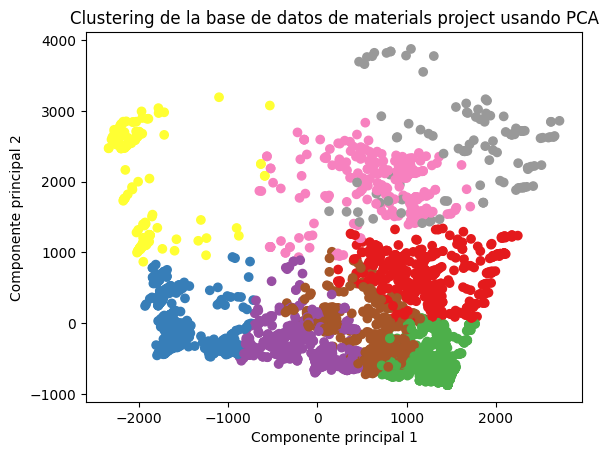

In [31]:
# Según la gráfica, se observa que el valor óptimo de k es 6, ya que a partir de ese punto la curva se suaviza
# Por lo tanto, se crea el modelo de KMeans con k=6 y se obtienen las etiquetas de los grupos asignados a cada material
models = []
labels_all = []
for i in range(3,9):
    model = KMeans(n_clusters=i, random_state=0)
    model.fit(X_df)
    labels = model.labels_
    models.append(model)
    labels_all.append(labels)

# Evaluar el resultado del clustering usando alguna medida de calidad
# En este ejemplo, se usan el coeficiente de silueta y el índice Davies-Bouldin, que miden la cohesión y la separación de los grupos
# El coeficiente de silueta varía entre -1 y 1, siendo 1 el mejor valor posible
# El índice Davies-Bouldin varía entre 0 e infinito, siendo 0 el mejor valor posible
for i in range(0,len(labels_all)):
    silhouette = silhouette_score(X_df, labels_all[i])
    davies_bouldin = davies_bouldin_score(X_df, labels_all[i])
    print(f"Coeficiente de silueta: {silhouette:.2f} con {i+3} clusters")
    print(f"Índice Davies-Bouldin: {davies_bouldin:.2f} con {i+3} clusters")

# Visualizar el resultado del clustering usando alguna técnica de proyección o gráfica
# En este ejemplo, se usa el análisis de componentes principales (PCA) para reducir la dimensionalidad de los datos a dos dimensiones y graficar los puntos con colores según su grupo
for i in range(0,len(labels_all)):
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_df)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_all[i], cmap="Set1")
    plt.xlabel("Componente principal 1")
    plt.ylabel("Componente principal 2")
    plt.title("Clustering de la base de datos de materials project usando PCA")
    plt.show()


In [17]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np


def sim_matrix(features, labels):
    useful_labels = labels >= 0

    # primero ordenamos los datos en base al cluster que pertencen
    indices = np.argsort(labels[useful_labels])
    sorted_features = features[useful_labels][indices]

    # calculamos las distancias entre todos los puntos
    d = euclidean_distances(sorted_features, sorted_features)
    return d

def plot(data, model, is_model = True):
    if is_model:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

        fig.suptitle(f"{model.__class__.__name__}")

        ax1.scatter(data[:,0], data[:,1], c=model.labels_)

        dist = sim_matrix(data, model.labels_)
        im = ax2.imshow(dist, cmap="jet")
        fig.colorbar(im, ax=ax2)
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

        fig.suptitle('Clustering Jerárquico')

        ax1.scatter(data[:,0], data[:,1], c = model)

        dist = sim_matrix(data, model)
        im = ax2.imshow(dist, cmap="jet")
        fig.colorbar(im, ax=ax2)


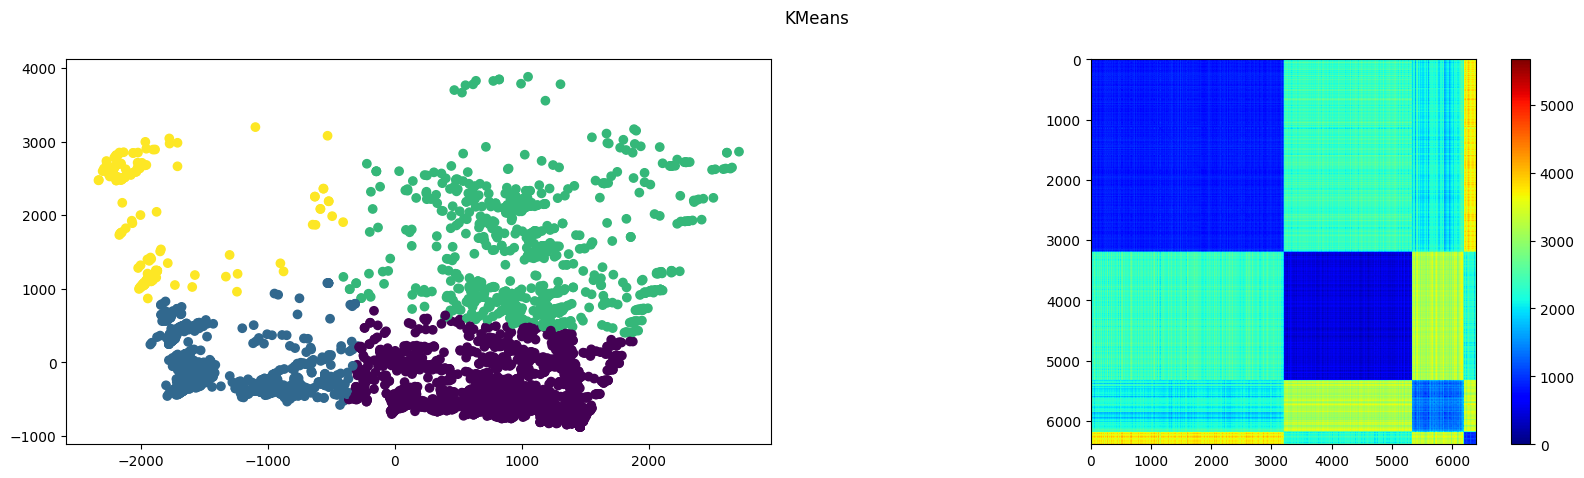

In [32]:
plot(X_pca, models[1])

In [23]:
from sklearn import metrics

# Asume que 'labels_kmeans' son las etiquetas de tu modelo K-Means,
# 'labels_complete' son las etiquetas de tu modelo de clustering jerárquico,
# y 'labels_dbscan' son las etiquetas de tu modelo DBSCAN

silhouette_kmeans3 = metrics.silhouette_score(X, labels)

print(f'Silhouette Score K-Means: {silhouette_kmeans3} con 6 clusters')

Silhouette Score K-Means: 0.517161231347029 con 6 clusters


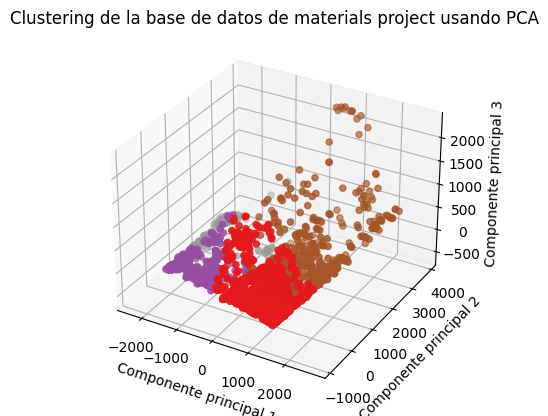

In [34]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels_all[1], cmap="Set1")

ax.set_xlabel("Componente principal 1")
ax.set_ylabel("Componente principal 2")
ax.set_zlabel("Componente principal 3")
plt.title("Clustering de la base de datos de materials project usando PCA")
plt.show()


In [12]:
# Imprimir la varianza explicada por cada componente principal
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)

# Imprimir los coeficientes de las variables originales en las componentes principales
print("\nCoeficientes de las variables originales en las componentes principales:")
print(pca.components_)

Varianza explicada por cada componente:
[0.84855944 0.09176778 0.04265384]

Coeficientes de las variables originales en las componentes principales:
[[ 1.55750681e-04  3.39498830e-03  3.23923762e-03 -1.38618647e-04
  -2.02976311e-05 -1.44447867e-04  1.31435968e-03 -1.55607632e-04
  -1.46996732e-03  1.51364113e-04 -6.98316919e-05 -1.04067565e-05
   3.05511000e-04  8.65757215e-03  8.35206115e-03 -2.89799894e-04
   4.09338212e-05 -3.20833213e-04  8.90013266e-04  6.99592494e-01
   6.98702481e-01  9.00361131e-02  1.10542454e-01  4.31799764e-02
   9.12116651e-05 -1.62942143e-05 -1.07505879e-04 -8.32130646e-05
   8.17063937e-05 -1.08313868e-04  2.17202216e-05  1.89175262e-04
   1.67455041e-04 -1.59444108e-05 -8.89769698e-06 -1.33589805e-05
   7.88214564e-04  7.46121973e-04 -4.20925909e-05 -4.24890790e-04
  -3.19691780e-05 -3.28084550e-04  2.78786723e-05 -2.74763113e-06
  -3.06263034e-05  1.91040992e-05 -2.81422432e-05 -1.09072903e-05
  -2.80337932e-05 -0.00000000e+00  2.80337932e-05 -7.143288

In [28]:
df

,Unnamed: 0,builder_meta,nsites,elements,nelements,composition,composition_reduced,formula_pretty,formula_anonymous,chemsys,...,weighted_surface_energy,weighted_work_function,surface_anisotropy,shape_factor,has_reconstructed,possible_species,has_props,theoretical,database_IDs,fields_not_requested
0,0,emmet_version='0.38.6' pymatgen_version='2022....,9,"[Element Ca, Element Li, Element Pb]",3,Li3 Ca3 Pb3,Li1 Ca1 Pb1,LiCaPb,ABC,Ca-Li-Pb,...,NaN,NaN,NaN,NaN,NaN,[],"[<HasProps.provenance: 'provenance'>, <HasProp...",False,{'icsd': ['icsd-409533']},[]
1,1,emmet_version='0.38.6' pymatgen_version='2022....,28,"[Element Cu, Element F, Element K]",3,K8 Cu4 F16,K2 Cu1 F4,K2CuF4,AB2C4,Cu-F-K,...,NaN,NaN,NaN,NaN,NaN,"['Cu2+', 'F-', 'K+']","[<HasProps.provenance: 'provenance'>, <HasProp...",True,{},[]
2,2,emmet_version='0.38.6' pymatgen_version='2022....,10,"[Element B, Element Fe]",2,Fe2 B8,Fe1 B4,FeB4,AB4,B-Fe,...,NaN,NaN,NaN,NaN,NaN,[],"[<HasProps.provenance: 'provenance'>, <HasProp...",False,"{'icsd': ['icsd-196424', 'icsd-425311']}",[]
3,3,emmet_version='0.38.6' pymatgen_version='2022....,12,"[Element Al, Element Hf, Element Mn]",3,Hf4 Mn4 Al4,Hf1 Mn1 Al1,HfMnAl,ABC,Al-Hf-Mn,...,NaN,NaN,NaN,NaN,NaN,[],"[<HasProps.provenance: 'provenance'>, <HasProp...",True,{},[]
4,4,emmet_version='0.38.6' pymatgen_version='2022....,12,"[Element Ni, Element Si, Element W]",3,Si2 Ni6 W4,Si1 Ni3 W2,SiNi3W2,AB2C3,Ni-Si-W,...,NaN,NaN,NaN,NaN,NaN,[],"[<HasProps.provenance: 'provenance'>, <HasProp...",True,{},[]
5,5,emmet_version='0.38.6' pymatgen_version='2022....,32,"[Element Co, Element Li, Element Mn, Element O]",4,Li9 Mn2 Co5 O16,Li9 Mn2 Co5 O16,Li9Mn2Co5O16,A2B5C9D16,Co-Li-Mn-O,...,NaN,NaN,NaN,NaN,NaN,"['Co4+', 'Mn3+', 'Li+', 'Co3+', 'O2-']","[<HasProps.provenance: 'provenance'>, <HasProp...",True,{},[]
6,6,emmet_version='0.38.6' pymatgen_version='2022....,6,"[Element Al, Element Ge, Element Nd]",3,Nd2 Al3 Ge1,Nd2 Al3 Ge1,Nd2Al3Ge,AB2C3,Al-Ge-Nd,...,NaN,NaN,NaN,NaN,NaN,[],"[<HasProps.provenance: 'provenance'>, <HasProp...",True,{},[]
7,7,emmet_version='0.38.6' pymatgen_version='2022....,8,"[Element Cd, Element In, Element Mg]",3,Mg6 Cd1 In1,Mg6 Cd1 In1,Mg6CdIn,ABC6,Cd-In-Mg,...,NaN,NaN,NaN,NaN,NaN,[],"[<HasProps.provenance: 'provenance'>, <HasProp...",True,{},[]
8,8,emmet_version='0.38.6' pymatgen_version='2022....,10,"[Element Hf, Element O, Element Sr, Element W]",4,Sr2 Hf1 W1 O6,Sr2 Hf1 W1 O6,Sr2HfWO6,ABC2D6,Hf-O-Sr-W,...,NaN,NaN,NaN,NaN,NaN,"['Hf4+', 'O2-', 'Sr2+', 'W4+']","[<HasProps.provenance: 'provenance'>, <HasProp...",True,{},[]
9,9,emmet_version='0.38.6' pymatgen_version='2022....,10,"[Element F, Element Fe, Element Mg, Element O]",4,Mg1 Fe3 O3 F3,Mg1 Fe3 O3 F3,MgFe3(OF)3,AB3C3D3,F-Fe-Mg-O,...,NaN,NaN,NaN,NaN,NaN,"['Fe3+', 'F-', 'O2-', 'Fe2+', 'Mg2+']","[<HasProps.provenance: 'provenance'>, <HasProp...",True,{},[]
